## Crop Classification in the Netherlands - Callisto Project - d'Andrimont area
This notebook will hold an end-to-end description, analysis and implementation of a crop classification in the Netherlands. The aim here is to have an implementation that will qualify to be considered as a baseline. We can then enhance this baseline and build on top of it through experimentation on data preprocessing, model architecture and data fusion with other data sources, like Sentinel 1, Very High Resolution Satellite imagery, street-level imagery etc.

So for this notebook, the plan is to:
* Use only data coming from Sentinel 2
* Apart from the available bands, create some common indices as well, like the Normalized Difference Vegetation Index (NDVI) and the Normalized Difference Water Index (NDWI)
* Apply a commonly used "shallow learning" method, like a Random Forest, which is popular for these kinds of tasks and evaluate the results on popular metrics like precision, recall, f1 etc.
* Apply a very simple deep learning network architecture and evaluate the same metrics as above.

### Prerequisites and Assumptions
For this notebook run, we consider that we have a few prerequisites in place. You will find the default values (like filenames being set) in the following block. If neither the prerequisites already exist, nor you know how to make it happen, just reach out to us, the AgriHub team, for futher information:
* A feature space file (or files) should be available. The folder and filename configuration values are being set in the next block.
  * In order to generate this file (or these files), we need to
    1. download the corresponding Sentinel imagery
    2. apply the required preprocessing steps and
    3. generate the feature space
  * All the above, happen in a semi-automated way, through the use of scripts that already exist.
  * The description of the scripts for the download, preprocess and feature space generation are not in scope for this notebook. However, separate notebooks will be created and linked to this.
* A shapefile should be available.
  * Similar to the feature space file(s), in the next block the folder and configuration values for this are being set.

### Configuration and default values
The corresponding configuration and default values for the aforementioned prerequisites are as follows. Feel free to change them accordingly if needed:

In [1]:
# Directory and filename(s) of the feature space
FEATURE_SPACE_DIR = '/nfs/data2/netherlands/gc/s2/2017/feature_spaces'
FEATURE_SPACE_FILENAMES = [
    '2017_03_04_05_fs_dandrimont_gc.csv',
    '2017_06_07_fs_dandrimont_gc.csv',
    '2017_08_fs_dandrimont_gc.csv',
    '2017_09_fs_dandrimont_gc.csv',
    '2017_10_fs_dandrimont_gc.csv',
    '2017_11_fs_dandrimont_gc.csv',
]

# Directory and filename for the shape file
SHAPEFILE_DIR = '/home/noa2/Desktop/Callisto/shapefiles'
SHAPEFILE = 'lpis_dandrimond_3857.shp'

### Python libraries used
The libraries that we will need are the following:
* **`pandas`** to efficiently handle the input csv files as a dataframe
* **`numpy`** to perform the necessary processing using numpy arrays
* **`matplotlib.pyplot`** for fancy plotting
* **`geopandas`** to process the geospatial information
* **`subprocess`** to run and get the output of some simple commands as if we were using a terminal
* **`os`** for simple utility purposes, like fail-proof path joining 
* **`datetime`** for some transformations that will be needed using the timestamps of our inputs
* **`train_test_split`** to easily split the final version of our data, after preprocessing into a train and a test part
* **`RandomForestClassifier`** for one of our baseline classifiers which will be a Random Forest
* **`classification_report`** to present the baseline classification results easily with metrics like the precision, recall and f1 score
* **`plot_confusion_matrix`** for a fancy plot of the classification results
* **`models`** and **`layers`** from keras to create our neural network architecture
* **`LabelEncoder`** from sklearn preprocessing and `to_categorical` from keras utils to transform the neural network input appropriately.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import subprocess
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from keras import models
from keras import layers
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

### Reading the feature space files and merging them into one
In this case, we don't already have the feature space avaialble in a single file. We rather have a few feature space files, each corresponding to a specific month or set of months. The filenames are shared as a list in the corresponding configuration item.

Here is a list of the separate feature space files we have available:

In [3]:
output = subprocess.check_output('ls -lh {0}'.format(FEATURE_SPACE_DIR),encoding='UTF-8',shell=True)
print(output)

total 176M
-rw-rw-r-- 1 noa2 noa2 24M Aug 23 15:08 2017_03_04_05_fs_dandrimont_gc.csv
-rw-rw-r-- 1 noa2 noa2 30M Aug 24 00:16 2017_06_07_fs_dandrimont_gc.csv
-rw-rw-r-- 1 noa2 noa2 40M Aug 25 00:43 2017_08_fs_dandrimont_gc.csv
-rw-rw-r-- 1 noa2 noa2 31M Aug 24 21:00 2017_09_fs_dandrimont_gc.csv
-rw-rw-r-- 1 noa2 noa2 29M Aug 25 08:01 2017_10_fs_dandrimont_gc.csv
-rw-rw-r-- 1 noa2 noa2 26M Aug 25 10:42 2017_11_fs_dandrimont_gc.csv



Let's have a look at how one of them looks like. We will read it into a pandas dataframe.

In [4]:
pd.read_csv(os.path.join(FEATURE_SPACE_DIR, FEATURE_SPACE_FILENAMES[-1]))

,id,November042017_B02,November042017_B03,November042017_B04,November042017_B05,November042017_B06,November042017_B07,November042017_B08,November042017_B8A,November042017_B11,...,November242017_B02,November242017_B03,November242017_B04,November242017_B05,November242017_B06,November242017_B07,November242017_B08,November242017_B8A,November242017_B11,November242017_B12
0,1,408.30768,498.51282,329.56412,774.84610,1804.4103,2169.3845,2186.3076,2437.8206,1258.9487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,449.76453,658.78540,417.67510,968.53350,2106.2578,2420.4084,2566.7944,2579.6528,1290.1342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,466.58777,723.11570,398.06763,1066.83620,2857.7307,3387.1392,3462.5630,3535.1497,1679.5618,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,482.64865,618.71620,409.18918,992.44590,2462.5810,3077.0134,3290.5945,3385.3918,1779.6892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,478.85553,708.98500,357.43713,1058.19700,3435.2927,4352.8145,4533.7090,4574.1520,1973.3452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55034,55035,448.33334,619.86664,441.86667,920.93335,2082.1333,2548.8000,3106.2000,2977.0000,1561.4000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55035,55036,530.34906,771.06604,462.02830,1191.06600,3238.3867,3853.9812,4109.1320,4092.4150,2112.1980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55036,55037,399.64590,623.66880,306.78360,979.44260,3309.0198,4163.7803,4402.7970,4411.3410,1848.5082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55037,55038,565.81396,777.16280,629.76746,1205.74410,2218.2092,2590.0930,2998.5580,2953.8604,1954.9070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
pd.read_csv(os.path.join(FEATURE_SPACE_DIR, FEATURE_SPACE_FILENAMES[-2]))

,id,October032017_B02,October032017_B03,October032017_B04,October032017_B05,October032017_B06,October032017_B07,October032017_B08,October032017_B8A,October032017_B11,...,October302017_B02,October302017_B03,October302017_B04,October302017_B05,October302017_B06,October302017_B07,October302017_B08,October302017_B8A,October302017_B11,October302017_B12
0,1,281.02500,481.12500,260.82500,773.95000,2612.2000,3174.0750,3176.0500,3460.7000,1461.90000,...,225.80000,396.15000,237.17500,641.82500,1769.7000,2251.9250,2213.2500,2518.6500,1165.5250,582.52500
1,2,331.90646,731.84174,301.82590,1159.01440,4054.9956,4853.0864,5121.4160,5126.0620,1797.36400,...,316.17980,627.95905,386.50146,969.04240,2136.5513,2360.6697,2567.7866,2549.7120,1216.9122,628.34503
2,3,394.35843,823.61816,356.62598,1284.72990,4756.3090,5835.5960,6056.0728,6073.6846,2138.44800,...,308.76492,661.87274,330.01428,1022.68964,2823.6013,3204.4844,3319.4440,3385.8376,1467.5377,699.18700
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,294.09460,554.51350,307.24326,957.87836,2804.9866,3391.3513,3719.6216,3679.7837,1784.8513,944.79730
4,5,309.44464,593.05164,273.14206,895.16790,2956.7104,3545.4980,3735.1770,3727.4392,1495.83400,...,329.61438,666.41880,300.16235,1062.06640,3717.4336,4547.8984,4833.9150,4791.8765,1954.7694,976.39300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55034,55035,189.73334,259.73334,138.73334,308.66666,943.8000,1249.0667,1457.9333,1386.9333,494.93332,...,311.13333,511.33334,334.13333,842.86664,2181.8000,2699.8000,3228.6667,2931.2666,1507.4667,821.00000
55035,55036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,320.85715,481.83810,261.77142,645.65717,1774.3810,2030.9714,2136.6477,2146.1428,936.2286,502.50476
55036,55037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,523.63605,711.23280,492.02620,864.01965,2132.0525,2448.1245,2619.9016,2576.2000,1152.5770,734.98360
55037,55038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,580.09520,732.28570,582.61900,896.76190,1650.6904,1835.8810,1999.7620,1999.9048,1113.3572,767.47620


### Create the initial merged feature space
We will now go through the list of the feature space files and merge them into a single pandas dataframe.

In [6]:
# Read the first feature space file
feature_space = pd.read_csv(os.path.join(FEATURE_SPACE_DIR,FEATURE_SPACE_FILENAMES[0]))

# If more than 1 files exist, start merging them into a single dataframe
if len(FEATURE_SPACE_FILENAMES) > 1:
    for file in FEATURE_SPACE_FILENAMES[1:]:
        feature_space = pd.merge(feature_space, pd.read_csv(os.path.join(FEATURE_SPACE_DIR, file)), on='id')

And this is how the merged feature space dataframe looks like:

In [7]:
feature_space

,id,March242017_B02,March242017_B03,March242017_B04,March242017_B05,March242017_B06,March242017_B07,March242017_B08,March242017_B8A,March242017_B11,...,November242017_B02,November242017_B03,November242017_B04,November242017_B05,November242017_B06,November242017_B07,November242017_B08,November242017_B8A,November242017_B11,November242017_B12
0,1,641.72500,864.30000,845.65000,1357.5000,2244.7500,2450.5000,2696.8500,2781.9250,2414.0250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,533.67303,807.45890,594.94867,1276.6349,3062.9340,3494.6025,3803.0308,3658.7068,1890.4912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,702.16800,938.61707,863.29614,1335.7906,2242.1997,2450.0125,2557.7893,2585.0234,1946.0936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,610.59460,795.82434,708.25680,1250.2028,2345.6216,2638.9055,2760.2974,2910.6620,2271.6892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,496.84418,747.97240,461.32150,1175.3708,3412.9448,4067.8955,4473.5030,4266.1480,1937.1006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55034,55035,854.00000,1082.46670,1037.73330,1572.9333,2631.7334,3004.7334,3053.4000,3273.7334,2504.8667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55035,55036,544.28300,752.98114,569.88680,1166.8113,2520.7830,2836.5754,3126.2075,3037.0850,1884.9906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55036,55037,340.74840,523.08810,382.09433,831.9497,1994.1195,2266.3962,2581.5283,2399.7737,1224.3019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55037,55038,490.39536,658.53490,589.53490,1053.7210,1892.1163,2150.2559,2412.2790,2409.1162,1998.6976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What we can initially notice is that we have quite a lot `NaN` values. Depending on the subsequent modelling choices, these can have varying impact levels on the results. We will have to deal with those values and we have quite a few ways to do that. For example:
* We can use a simple linear interpolation which will replace `NaN`s with actual values or
* We can convert `NaN`s to zeroes.

Also, we have to consider applying normalisation to the values of the dataset so that each column is centered around 0 with a standard deviation of 1.

Let's see how many NaN values there are for each feature/column:

In [8]:
feature_space_nans = feature_space.isna().sum().sort_values()
feature_space_nans

id                         0
May262017_B12             69
May262017_B8A             69
May262017_B08             69
May262017_B07             69
                       ...  
July272017_B8A         55039
July272017_B11         55039
July272017_B12         55039
July272017_B03         55039
September182017_B11    55039
Length: 481, dtype: int64

This is quite interesting as not only do we have quite a lot of NaN values, but for specific months and bands, all of them actually are `NaN`. It's probably a great reason to just drop these columns later on, but let's just continue naively for the moment.

### Cloud cover as a root cause for `NaN` values

As far as I can understand, `NaN` values also correspond to cloud cover (need to verify this though and further justify here). We will keep the acquisitions with less than 95% cloud cover, so we will drop the columns for which more than 95% of their values are `NaN`.

In [9]:
# Check which of the columns have less than 5% `NaN` values
cols_to_keep = feature_space.columns[(feature_space.isna().sum(axis = 0)/len(feature_space))<0.95]
print("Here are the column names for which we have less than 5% NaN values:")
for c in cols_to_keep:
    print(" {}".format(c))


Here are the column names for which we have less than 5% NaN values:
 id
 March242017_B02
 March242017_B03
 March242017_B04
 March242017_B05
 March242017_B06
 March242017_B07
 March242017_B08
 March242017_B8A
 March242017_B11
 March242017_B12
 March272017_B02
 March272017_B03
 March272017_B04
 March272017_B05
 March272017_B06
 March272017_B07
 March272017_B08
 March272017_B8A
 March272017_B11
 March272017_B12
 April262017_B02
 April262017_B03
 April262017_B04
 April262017_B05
 April262017_B06
 April262017_B07
 April262017_B08
 April262017_B8A
 April262017_B11
 April262017_B12
 May062017_B02
 May062017_B03
 May062017_B04
 May062017_B05
 May062017_B06
 May062017_B07
 May062017_B08
 May062017_B8A
 May062017_B11
 May062017_B12
 May262017_B02
 May262017_B03
 May262017_B04
 May262017_B05
 May262017_B06
 May262017_B07
 May262017_B08
 May262017_B8A
 May262017_B11
 May262017_B12
 June022017_B02
 June022017_B03
 June022017_B04
 June022017_B05
 June022017_B06
 June022017_B07
 June022017_B08
 June

And here are the ones we will drop because of >= 5% `NaN` values:

In [10]:
cols_to_drop = [x for x in feature_space.columns if x not in cols_to_keep]
print("And these are the columns which have >= 5% NaN values and will be dropped:")
for c in cols_to_drop:
    print(" {}".format(c))

And these are the columns which have >= 5% NaN values and will be dropped:
 July272017_B02
 July272017_B03
 July272017_B04
 July272017_B05
 July272017_B06
 July272017_B07
 July272017_B08
 July272017_B8A
 July272017_B11
 July272017_B12
 September182017_B02
 September182017_B03
 September182017_B04
 September182017_B05
 September182017_B06
 September182017_B07
 September182017_B08
 September182017_B8A
 September182017_B11
 September182017_B12
 November122017_B02
 November122017_B03
 November122017_B04
 November122017_B05
 November122017_B06
 November122017_B07
 November122017_B08
 November122017_B8A
 November122017_B11
 November122017_B12
 November242017_B02
 November242017_B03
 November242017_B04
 November242017_B05
 November242017_B06
 November242017_B07
 November242017_B08
 November242017_B8A
 November242017_B11
 November242017_B12


There is one thing to notice here. For each of the acquisition dates, we don't have 1, but a few different columns/features. In particular, for each date, we have (for the moment) 10 different columns that correspond to the different bands that are acquired by the Sentinel-2 instruments. These bands are `B02, B03, B04, B05, B06, B07, B08, B8A, B11, B12`.

Given we consider that cloud cover will lead to `NaN` values, we expect that this should apply to all the corresponding bands of each affected date. And this is indeed the case. As can be seen above, the columns that are excluded are coming from 4 different dates
1. July 27, 2017
2. September 18, 2017
3. November 12, 2017
4. November 24, 2017

And for each one of them we have 10 different columns, that correspond to the 10 different bands of acquisition.

This is important for a particular reason. We will generate indices like the Normalized Difference Vegetation Index (NDVI) and Normalized Difference Water Index (NDWI). In order to do that we need the values from specific Sentinel-2 bands. If we were to drop only specific parts of each acquisition, then we would have to separately check when we have the necessary band availability for their calcualtion. Now that the cloud cover has a consistent impact on the data availability (ie. none of the bands for the specific dates are available) we know that there is no check we have to perform whatsoever.

This is not necessarily good, as the more data we have, the better, but at least it makes our lives easier with regards to the preprocessing complexity.

### Keep features where cloud cover is less than 5%
Time to actually update our feature space dataset by keeping only the features for which cloud cover is not really important. We already found the corresponding columns previously (`cols_to_keep` variable), so it's a matter of keeping only them in the feature space dataframe.

In [11]:
# Keep only the columns which have less than 5% cloud coverage (less than 5% NaN values)
feature_space = feature_space[cols_to_keep]

This is what the feature space now looks like

In [12]:
feature_space

,id,March242017_B02,March242017_B03,March242017_B04,March242017_B05,March242017_B06,March242017_B07,March242017_B08,March242017_B8A,March242017_B11,...,November192017_B02,November192017_B03,November192017_B04,November192017_B05,November192017_B06,November192017_B07,November192017_B08,November192017_B8A,November192017_B11,November192017_B12
0,1,641.72500,864.30000,845.65000,1357.5000,2244.7500,2450.5000,2696.8500,2781.9250,2414.0250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,533.67303,807.45890,594.94867,1276.6349,3062.9340,3494.6025,3803.0308,3658.7068,1890.4912,...,537.88983,850.35364,578.12665,1327.03610,2876.8618,3196.4983,3424.3948,3436.9473,1614.14310,916.92430
2,3,702.16800,938.61707,863.29614,1335.7906,2242.1997,2450.0125,2557.7893,2585.0234,1946.0936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,610.59460,795.82434,708.25680,1250.2028,2345.6216,2638.9055,2760.2974,2910.6620,2271.6892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,496.84418,747.97240,461.32150,1175.3708,3412.9448,4067.8955,4473.5030,4266.1480,1937.1006,...,297.12915,576.51843,282.11070,980.93910,3172.7454,3807.9963,4047.9521,4033.0535,1622.27670,821.20110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55034,55035,854.00000,1082.46670,1037.73330,1572.9333,2631.7334,3004.7334,3053.4000,3273.7334,2504.8667,...,281.06668,440.46667,375.40000,726.20000,1338.2000,1574.2000,1924.9333,1793.4000,943.86664,548.80000
55035,55036,544.28300,752.98114,569.88680,1166.8113,2520.7830,2836.5754,3126.2075,3037.0850,1884.9906,...,366.87735,666.63210,389.71698,1116.96230,2980.8300,3441.8584,3724.6604,3718.6416,1577.00000,802.31134
55036,55037,340.74840,523.08810,382.09433,831.9497,1994.1195,2266.3962,2581.5283,2399.7737,1224.3019,...,673.58026,981.60490,653.22220,1467.65430,4133.6050,4851.2593,5378.4690,5287.6790,2344.33330,1434.19750
55037,55038,490.39536,658.53490,589.53490,1053.7210,1892.1163,2150.2559,2412.2790,2409.1162,1998.6976,...,1136.28210,1494.35900,1447.69230,2248.05130,3802.7950,4271.3335,4181.4360,4773.1540,2953.66670,2449.41020


### Generating additional indices - NDVI / NDWI / PSRI
We will now enhance our feature space with 3 useful indices, namely the
* NDVI - Normalized Difference Vegetation Index
* NDWI - Normalized Difference Water Index
* PSRI - Plant Senescence Reflectance Index

To do that we will just have to combine the Sentinel-2 bands in the following ways:
\
$NDVI = 1000 * \frac {B8+B4} {B8+B4}$
\
\
$NDWI = 1000 * \frac {B8-B11} {B8+B11}$
\
\
$PSRI = 1000 * \frac {B4-B2} {B6}$

The following code block takes care of the creation of these indices:

In [13]:
# Create the NDVI, NDWI and PSRI indices and insert them into the feature space

i = 1
num_features = 10
while i < len(feature_space.columns[1:]):
    # Get the date out of the column name
    date = feature_space.columns[i].split("_")[0]

    # Get the band values
    b2 = feature_space.iloc[:,i]
    b4 = feature_space.iloc[:,i+2]
    b5 = feature_space.iloc[:,i+3]
    b6 = feature_space.iloc[:,i+4]
    b7 = feature_space.iloc[:,i+5]
    b8 = feature_space.iloc[:,i+6]
    b8a = feature_space.iloc[:,i+7]
    b11 = feature_space.iloc[:,i+8]

    # Calculate NDVI, NDWI and PSRI indices
    ndvi = 1000*(b8-b4) / (b8+b4)
    ndwi = 1000*(b8-b11) / (b8+b11)
    psri = 1000*(b4-b2) / b6

    # Insert the newly calculated indices to the feature space
    feature_space.insert(loc=i+num_features, column=date + "_NDVI", value=ndvi)
    feature_space.insert(loc=i+num_features+1, column=date + "_NDWI", value=ndwi)
    feature_space.insert(loc=i+num_features+2, column=date + "_PSRI", value=psri)

    # Prepare for the next iteration
    i += num_features+3

Checking our feature space again, we will now be able to see the newly generated indices as new columns:

In [14]:
feature_space

,id,March242017_B02,March242017_B03,March242017_B04,March242017_B05,March242017_B06,March242017_B07,March242017_B08,March242017_B8A,March242017_B11,...,November192017_B05,November192017_B06,November192017_B07,November192017_B08,November192017_B8A,November192017_B11,November192017_B12,November192017_NDVI,November192017_NDWI,November192017_PSRI
0,1,641.72500,864.30000,845.65000,1357.5000,2244.7500,2450.5000,2696.8500,2781.9250,2414.0250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,533.67303,807.45890,594.94867,1276.6349,3062.9340,3494.6025,3803.0308,3658.7068,1890.4912,...,1327.03610,2876.8618,3196.4983,3424.3948,3436.9473,1614.14310,916.92430,711.118775,359.281152,13.986358
2,3,702.16800,938.61707,863.29614,1335.7906,2242.1997,2450.0125,2557.7893,2585.0234,1946.0936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,610.59460,795.82434,708.25680,1250.2028,2345.6216,2638.9055,2760.2974,2910.6620,2271.6892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,496.84418,747.97240,461.32150,1175.3708,3412.9448,4067.8955,4473.5030,4266.1480,1937.1006,...,980.93910,3172.7454,3807.9963,4047.9521,4033.0535,1622.27670,821.20110,869.696717,427.791450,-4.733582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55034,55035,854.00000,1082.46670,1037.73330,1572.9333,2631.7334,3004.7334,3053.4000,3273.7334,2504.8667,...,726.20000,1338.2000,1574.2000,1924.9333,1793.4000,943.86664,548.80000,673.612515,341.978068,70.492692
55035,55036,544.28300,752.98114,569.88680,1166.8113,2520.7830,2836.5754,3126.2075,3037.0850,1884.9906,...,1116.96230,2980.8300,3441.8584,3724.6604,3718.6416,1577.00000,802.31134,810.558467,405.092035,7.662171
55036,55037,340.74840,523.08810,382.09433,831.9497,1994.1195,2266.3962,2581.5283,2399.7737,1224.3019,...,1467.65430,4133.6050,4851.2593,5378.4690,5287.6790,2344.33330,1434.19750,783.403302,392.880147,-4.925013
55037,55038,490.39536,658.53490,589.53490,1053.7210,1892.1163,2150.2559,2412.2790,2409.1162,1998.6976,...,2248.05130,3802.7950,4271.3335,4181.4360,4773.1540,2953.66670,2449.41020,485.642457,172.074510,81.889821


### Preparing for Interpolation
Before we can proceed with filling our `NaN` gaps in the data, we still have to apply a couple of transformations.

The current format of the column names follows the convention of `MonthDDYYYY_Band` where:
* **Month** is the full month name, eg. `March`, `April`, `June`, `July` etc.
* **DD** is the 2-digit day of month, eg. `01`, `02`, ..., `09`, `10`, `11`, ...
* **YYYY** is the 4-digit year, in our case `2017`
* **Band** is the sentinel band (either existing or derived) that the column represents, eg. `B02`, `B03`, ..., `NDVI` etc.

In order to apply interpolation, we will define a few utility functions. Through their use, we will change the names from the above format, into `Band_DDD`, where:
* **Band** is the sentinel band (either existing or derived) that the column represents, eg. `B02`, `B03`, ..., `NDVI` etc.
* **DDD** is the 3-digit (zero padded) day of year, eg. `001`, `002`, ..., `158`, `159`, ...

Then we will become able to apply the utility function that performs simple linear interpolation.

#### Utility functions - Brief reference
Note that this is (at least currently) not a documentation-detailed reference, but just a simple heads up of the utilities that have been created and their purpose. A full documentation will become available shortly.
* `change_colnames` -- returns a list of column names transformed from the `MonthDDYYYY_Band` to the `Band_DDD` format described above
* `doy_to_date` -- Gets the day of year and the year and returns a datetime object
* `get_band` -- Gets a dataframe and a band name. Returns the columns of the dataframe that hold values from this band.
* `simple_daily_interpolation` -- Applies interpolation for a specific band between days of year that are given as argument. The interpolation method defaults to `linear`.
* `daily_fs` -- Receives a dataframe, a band list and a range of days of year to apply interpolation.

#### Utility functions - Definition

In [15]:
#####################
# Utility Functions #
#####################

def change_colnames(df):
    cols = ["id"] + [x.split("_")[1] + "_" + str(datetime.strptime(x.split("_")[0], '%B%d%Y').timetuple().tm_yday) for x in df.columns[1:]]
    return cols


def doy_to_date(doy, year):
    return datetime.strptime(str(doy) + year, '%j%Y')


def get_band(df, band_name, with_id=False):
    bands = [x for x in df.columns if band_name in x]
    if with_id:
        bands = ["id"] + bands
    return df.loc[:, bands]


def simple_daily_interpolation(df, name, start_doy, end_doy, year='2021', interp_method='linear'):
    n_cols = df.shape[1]

    df.index = df.index.astype(int)
    df.columns = [int(x.split("_")[1]) for x in df]

    dates = []
    for col in df.columns:
        dates.append(doy_to_date(col, year))
    df.columns = np.asarray(dates)
    date_of_doy = doy_to_date(end_doy, year)
    if df.columns[-1] < date_of_doy:
        df[date_of_doy] = np.nan
    dfT = df.T
    dfT = dfT.resample('1d').asfreq()

    df_daily = dfT.T.interpolate(interp_method, axis=1).ffill(axis=1).bfill(axis=1)
    df_daily.columns = df_daily.columns.map(lambda t: "{}_{}".format(name, t.timetuple().tm_yday))
    return df_daily


def daily_fs(fs, year, start_doy, end_doy, bandnames, has_id=True, scale=False):
    band_list = []
    for b in bandnames:
        scale_const = 1 if scale == False else 100000 if b == 'BORI' else 1000
        band_df = get_band(fs, b)
        band_df = simple_daily_interpolation(band_df, b, start_doy, end_doy, year)
        band_df = band_df / scale_const
        band_list.append(band_df)
        print(b)
    fs_daily = pd.concat(band_list, axis=1, join='inner')
    cols = [x for x in fs_daily.columns if start_doy <= int(x.split("_")[1]) <= end_doy]
    if has_id:
        fs_daily.insert(0, 'id', fs["id"])
        cols = ["id"] + cols
    fs_daily = fs_daily[cols]
    return fs_daily

### Apply linear interpolation
The utility functions have been defined and the dataset is ready for interpolation. We will call the `daily_fs` function which takes care of interpolation. The arguments that it needs to receive are the following:
* the feature space (our dataset)
* the year (currently hardcoded - future improvement: derive this from the column names)
* the start day of year (currently hardcoded - future improvement: derive this from the column names)
* the end day of year (currently hardcoded - future improvement: derive this from the column names)
* the bands included in the feature space

There are also a couple of arguments that have default values (which are fine for our case):
* an indication of whether an id column exists in the dataset
* an indication of whether scaling needs to be applied

Let's make the appropriate calls. First to update the column names so that they have the band name followed by the day of year.

In [16]:
# Change the data column names (eg. from June222017_B03 to B03_100)
feature_space.columns = change_colnames(feature_space)
feature_space

,id,B02_83,B03_83,B04_83,B05_83,B06_83,B07_83,B08_83,B8A_83,B11_83,...,B05_323,B06_323,B07_323,B08_323,B8A_323,B11_323,B12_323,NDVI_323,NDWI_323,PSRI_323
0,1,641.72500,864.30000,845.65000,1357.5000,2244.7500,2450.5000,2696.8500,2781.9250,2414.0250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,533.67303,807.45890,594.94867,1276.6349,3062.9340,3494.6025,3803.0308,3658.7068,1890.4912,...,1327.03610,2876.8618,3196.4983,3424.3948,3436.9473,1614.14310,916.92430,711.118775,359.281152,13.986358
2,3,702.16800,938.61707,863.29614,1335.7906,2242.1997,2450.0125,2557.7893,2585.0234,1946.0936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,610.59460,795.82434,708.25680,1250.2028,2345.6216,2638.9055,2760.2974,2910.6620,2271.6892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,496.84418,747.97240,461.32150,1175.3708,3412.9448,4067.8955,4473.5030,4266.1480,1937.1006,...,980.93910,3172.7454,3807.9963,4047.9521,4033.0535,1622.27670,821.20110,869.696717,427.791450,-4.733582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55034,55035,854.00000,1082.46670,1037.73330,1572.9333,2631.7334,3004.7334,3053.4000,3273.7334,2504.8667,...,726.20000,1338.2000,1574.2000,1924.9333,1793.4000,943.86664,548.80000,673.612515,341.978068,70.492692
55035,55036,544.28300,752.98114,569.88680,1166.8113,2520.7830,2836.5754,3126.2075,3037.0850,1884.9906,...,1116.96230,2980.8300,3441.8584,3724.6604,3718.6416,1577.00000,802.31134,810.558467,405.092035,7.662171
55036,55037,340.74840,523.08810,382.09433,831.9497,1994.1195,2266.3962,2581.5283,2399.7737,1224.3019,...,1467.65430,4133.6050,4851.2593,5378.4690,5287.6790,2344.33330,1434.19750,783.403302,392.880147,-4.925013
55037,55038,490.39536,658.53490,589.53490,1053.7210,1892.1163,2150.2559,2412.2790,2409.1162,1998.6976,...,2248.05130,3802.7950,4271.3335,4181.4360,4773.1540,2953.66670,2449.41020,485.642457,172.074510,81.889821


And now the interpolation can be eventually be applied. This is expected to take some minute (not much though, maybe a couple of minutes).

In [17]:
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'NDWI', 'PSRI']

# March 24 was the 83rd day of 2017
# November 19 was the 323rd day of 2017
feature_space_interpolated = daily_fs(feature_space, year='2017', start_doy=83, end_doy=323, bandnames=bands)

# Note: Check the code to understand if and this is really needed and why.
feature_space_interpolated = feature_space_interpolated[feature_space.columns] # Keep the inital columns

B02
B03
B04
B05
B06
B07
B08
B8A
B11
B12
NDVI
NDWI
PSRI


Now that the interpolation was run successfully, let's see what our dataset looks like. We will drop rows with `NaN` values and have a look:

In [18]:
# Drop the NaNs
feature_space_interpolated = feature_space_interpolated.dropna()

# Show it - We want to see it
feature_space_interpolated

,id,B02_83,B03_83,B04_83,B05_83,B06_83,B07_83,B08_83,B8A_83,B11_83,...,B05_323,B06_323,B07_323,B08_323,B8A_323,B11_323,B12_323,NDVI_323,NDWI_323,PSRI_323
0,1,641.72500,864.30000,845.65000,1357.5000,2244.7500,2450.5000,2696.8500,2781.9250,2414.0250,...,692.02940,1330.0588,1542.3235,1584.0000,1773.4117,986.97060,497.70587,721.106362,232.219458,63.752166
1,2,533.67303,807.45890,594.94867,1276.6349,3062.9340,3494.6025,3803.0308,3658.7068,1890.4912,...,1327.03610,2876.8618,3196.4983,3424.3948,3436.9473,1614.14310,916.92430,711.118775,359.281152,13.986358
2,3,702.16800,938.61707,863.29614,1335.7906,2242.1997,2450.0125,2557.7893,2585.0234,1946.0936,...,912.20776,2820.7688,3326.7493,3540.0857,3465.8650,1423.89360,687.61300,865.668034,426.309614,3.342553
3,4,610.59460,795.82434,708.25680,1250.2028,2345.6216,2638.9055,2760.2974,2910.6620,2271.6892,...,1578.63510,3277.4324,3801.6758,4291.3240,4220.3920,2341.35130,1614.22970,670.926952,293.994898,34.552423
4,5,496.84418,747.97240,461.32150,1175.3708,3412.9448,4067.8955,4473.5030,4266.1480,1937.1006,...,980.93910,3172.7454,3807.9963,4047.9521,4033.0535,1622.27670,821.20110,869.696717,427.791450,-4.733582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55034,55035,854.00000,1082.46670,1037.73330,1572.9333,2631.7334,3004.7334,3053.4000,3273.7334,2504.8667,...,726.20000,1338.2000,1574.2000,1924.9333,1793.4000,943.86664,548.80000,673.612515,341.978068,70.492692
55035,55036,544.28300,752.98114,569.88680,1166.8113,2520.7830,2836.5754,3126.2075,3037.0850,1884.9906,...,1116.96230,2980.8300,3441.8584,3724.6604,3718.6416,1577.00000,802.31134,810.558467,405.092035,7.662171
55036,55037,340.74840,523.08810,382.09433,831.9497,1994.1195,2266.3962,2581.5283,2399.7737,1224.3019,...,1467.65430,4133.6050,4851.2593,5378.4690,5287.6790,2344.33330,1434.19750,783.403302,392.880147,-4.925013
55037,55038,490.39536,658.53490,589.53490,1053.7210,1892.1163,2150.2559,2412.2790,2409.1162,1998.6976,...,2248.05130,3802.7950,4271.3335,4181.4360,4773.1540,2953.66670,2449.41020,485.642457,172.074510,81.889821


### Load LPIS data
We will now load the shapefile containing the Land Parcel Identification Systems (LPIS) data for our area of interest in the Netherlands.

In [19]:
lpis = geopandas.read_file(os.path.join(SHAPEFILE_DIR, SHAPEFILE))

Let's see how many parcels we found in this file:

In [20]:
print("Parcels inside the lpis file: {0}".format(len(lpis)))

Parcels inside the lpis file: 55039


So we did read information for 55039 parcels, as expected. Let's have a look at the file dataset as well:

In [21]:
lpis

,CAT_GEWASC,GWS_GEWASC,GEOMETRIE_,GEOMETRI_1,GWS_GEWAS,id,geometry
0,Grasland,265,170.704927,1472.436561,"Grasland, blijvend",1,"POLYGON ((607260.186 6850944.822, 607260.491 6..."
1,Grasland,266,1083.416239,26008.169650,"Grasland, tijdelijk",2,"POLYGON ((607589.261 6849674.646, 607588.788 6..."
2,Grasland,266,858.443121,28843.493760,"Grasland, tijdelijk",3,"POLYGON ((607937.264 6851070.654, 607394.081 6..."
3,Bouwland,1098,516.104951,2783.437687,Peren. Aangeplant voorafgaande aan lopende sei...,4,"POLYGON ((551847.903 6809201.124, 551847.749 6..."
4,Grasland,265,911.993567,20414.915207,"Grasland, blijvend",5,"POLYGON ((551371.731 6827869.920, 551370.198 6..."
...,...,...,...,...,...,...,...
55034,Grasland,265,100.022431,504.525746,"Grasland, blijvend",55035,"POLYGON ((589995.209 6841226.222, 590003.944 6..."
55035,Grasland,265,400.141629,3930.653695,"Grasland, blijvend",55036,"POLYGON ((548720.576 6843754.469, 548700.911 6..."
55036,Grasland,265,558.913736,11432.118162,"Grasland, blijvend",55037,"POLYGON ((620079.799 6847006.063, 620093.376 6..."
55037,Grasland,265,168.449401,1558.859561,"Grasland, blijvend",55038,"POLYGON ((618496.803 6847468.779, 618466.965 6..."


### Keep the most prevalent crops and visualise LPIS
We will keep the **10 most prevalent** crops of the above data in order to run our baseline against. For this reason the `GWS_GEWASC` is to be used.

In [22]:
# Keep the 10 most prevalent crops
top_crop_codes = lpis.GWS_GEWASC.value_counts().head(10).index
top_crops = lpis.loc[lpis.GWS_GEWASC.isin(top_crop_codes)]

# The resulting LPIS dataset
top_crops

,CAT_GEWASC,GWS_GEWASC,GEOMETRIE_,GEOMETRI_1,GWS_GEWAS,id,geometry
0,Grasland,265,170.704927,1472.436561,"Grasland, blijvend",1,"POLYGON ((607260.186 6850944.822, 607260.491 6..."
1,Grasland,266,1083.416239,26008.169650,"Grasland, tijdelijk",2,"POLYGON ((607589.261 6849674.646, 607588.788 6..."
2,Grasland,266,858.443121,28843.493760,"Grasland, tijdelijk",3,"POLYGON ((607937.264 6851070.654, 607394.081 6..."
3,Bouwland,1098,516.104951,2783.437687,Peren. Aangeplant voorafgaande aan lopende sei...,4,"POLYGON ((551847.903 6809201.124, 551847.749 6..."
4,Grasland,265,911.993567,20414.915207,"Grasland, blijvend",5,"POLYGON ((551371.731 6827869.920, 551370.198 6..."
...,...,...,...,...,...,...,...
55034,Grasland,265,100.022431,504.525746,"Grasland, blijvend",55035,"POLYGON ((589995.209 6841226.222, 590003.944 6..."
55035,Grasland,265,400.141629,3930.653695,"Grasland, blijvend",55036,"POLYGON ((548720.576 6843754.469, 548700.911 6..."
55036,Grasland,265,558.913736,11432.118162,"Grasland, blijvend",55037,"POLYGON ((620079.799 6847006.063, 620093.376 6..."
55037,Grasland,265,168.449401,1558.859561,"Grasland, blijvend",55038,"POLYGON ((618496.803 6847468.779, 618466.965 6..."


Have a look at this fancy plot (ok, not very fancy).

<AxesSubplot:>

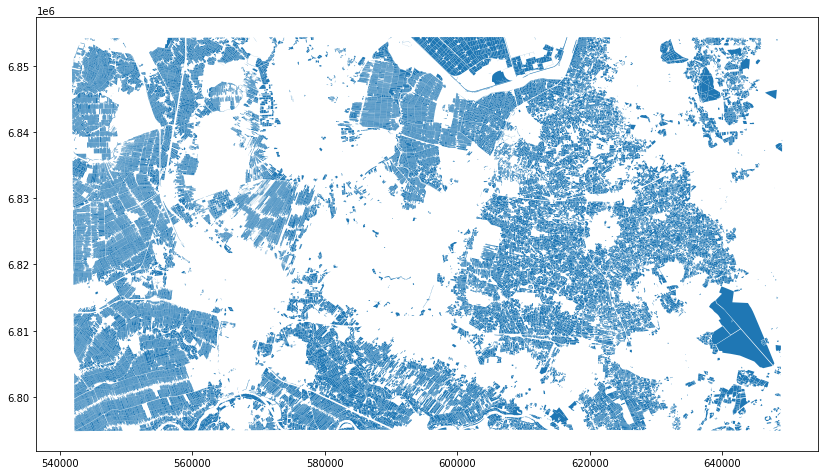

In [23]:
lpis.plot(figsize=(14,8.5))

### Merge our feature space with the LPIS dataset
We will now create our final dataset version. We will just merge the feature space with the LPIS data on their common column, ie, the `id`.

In [24]:
# Merge feature space with LPIS
netherlands_dandrimont_data = pd.merge(feature_space_interpolated, top_crops, on = 'id', how = 'inner')

It looks like this:

In [25]:
netherlands_dandrimont_data

,id,B02_83,B03_83,B04_83,B05_83,B06_83,B07_83,B08_83,B8A_83,B11_83,...,B12_323,NDVI_323,NDWI_323,PSRI_323,CAT_GEWASC,GWS_GEWASC,GEOMETRIE_,GEOMETRI_1,GWS_GEWAS,geometry
0,1,641.72500,864.30000,845.65000,1357.5000,2244.7500,2450.5000,2696.8500,2781.9250,2414.0250,...,497.70587,721.106362,232.219458,63.752166,Grasland,265,170.704927,1472.436561,"Grasland, blijvend","POLYGON ((607260.186 6850944.822, 607260.491 6..."
1,2,533.67303,807.45890,594.94867,1276.6349,3062.9340,3494.6025,3803.0308,3658.7068,1890.4912,...,916.92430,711.118775,359.281152,13.986358,Grasland,266,1083.416239,26008.169650,"Grasland, tijdelijk","POLYGON ((607589.261 6849674.646, 607588.788 6..."
2,3,702.16800,938.61707,863.29614,1335.7906,2242.1997,2450.0125,2557.7893,2585.0234,1946.0936,...,687.61300,865.668034,426.309614,3.342553,Grasland,266,858.443121,28843.493760,"Grasland, tijdelijk","POLYGON ((607937.264 6851070.654, 607394.081 6..."
3,4,610.59460,795.82434,708.25680,1250.2028,2345.6216,2638.9055,2760.2974,2910.6620,2271.6892,...,1614.22970,670.926952,293.994898,34.552423,Bouwland,1098,516.104951,2783.437687,Peren. Aangeplant voorafgaande aan lopende sei...,"POLYGON ((551847.903 6809201.124, 551847.749 6..."
4,5,496.84418,747.97240,461.32150,1175.3708,3412.9448,4067.8955,4473.5030,4266.1480,1937.1006,...,821.20110,869.696717,427.791450,-4.733582,Grasland,265,911.993567,20414.915207,"Grasland, blijvend","POLYGON ((551371.731 6827869.920, 551370.198 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51333,55035,854.00000,1082.46670,1037.73330,1572.9333,2631.7334,3004.7334,3053.4000,3273.7334,2504.8667,...,548.80000,673.612515,341.978068,70.492692,Grasland,265,100.022431,504.525746,"Grasland, blijvend","POLYGON ((589995.209 6841226.222, 590003.944 6..."
51334,55036,544.28300,752.98114,569.88680,1166.8113,2520.7830,2836.5754,3126.2075,3037.0850,1884.9906,...,802.31134,810.558467,405.092035,7.662171,Grasland,265,400.141629,3930.653695,"Grasland, blijvend","POLYGON ((548720.576 6843754.469, 548700.911 6..."
51335,55037,340.74840,523.08810,382.09433,831.9497,1994.1195,2266.3962,2581.5283,2399.7737,1224.3019,...,1434.19750,783.403302,392.880147,-4.925013,Grasland,265,558.913736,11432.118162,"Grasland, blijvend","POLYGON ((620079.799 6847006.063, 620093.376 6..."
51336,55038,490.39536,658.53490,589.53490,1053.7210,1892.1163,2150.2559,2412.2790,2409.1162,1998.6976,...,2449.41020,485.642457,172.074510,81.889821,Grasland,265,168.449401,1558.859561,"Grasland, blijvend","POLYGON ((618496.803 6847468.779, 618466.965 6..."


### Crop Classification Baseline  1 - Random Forest
We had a great time reading, preprocessing, plotting and merging the data. But even greater times lie ahead. We are ready to train our first baseline model for crop classification. And that will be a Random Forest.

Yes, you read that right, a Random Forest.

#### Splitting into a train and a test part
We will use the `train_test_split` module of sklearn to split our data.
* 80% of the data will be used for training
* 20% of the data will be used for testing
* All columns but the final 6 are the features we want to use as `X`
* The column holding the labels, thus the one we'll use as `y` is `CAT_GEWASC`
* A random state will be hardcoded for reproducibility. We will use 42 because it happens to be the answer to the meaning of life, the universe and everything.

In [26]:
X = netherlands_dandrimont_data.iloc[:,1:-6]
y = netherlands_dandrimont_data['CAT_GEWASC']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

#### Baseline Random Forest Classifier
If you have followed this document from the beginning, you probably can't wait to fit a Random Forest classifier to the data. Say no more, let's fit it right now (be patient though as it will need a few minutes to run):

In [27]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

#### Classification Results - Random Forest baseline evaluation
Our model was successfully fit. Time to generate predictions and use the `classification_report` module to evaluate the results:

In [28]:
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Bouwland       0.82      0.67      0.74      1220
     Grasland       0.95      0.98      0.96      8868
Natuurterrein       0.87      0.50      0.64       117
      Overige       0.78      0.57      0.66        63

     accuracy                           0.93     10268
    macro avg       0.85      0.68      0.75     10268
 weighted avg       0.93      0.93      0.93     10268



We seem to have achieved an overall accuracy of 93%. Not bad for a baseline classifier with a tiny amount of data preprocessing over a small area of interest.

But wait, there is one more fancy plot I can create:

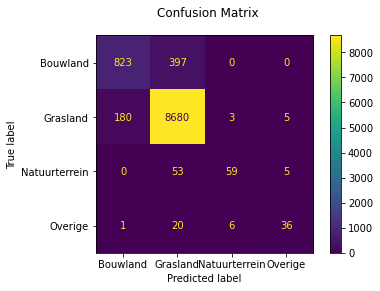

In [29]:
disp = plot_confusion_matrix(rf_clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.rcParams["figure.figsize"] = (14,8.5)
plt.show()

### Crop Classification Baseline  2 - Neural Network
Random Forest was nice, we all enjoyed it. However, we also want to fit a Neural Network because all the cool data scientists attack their problems with Neural Networks nowadays. And we happen to be cool data scientists as far as we can tell.

One-hot encode the labels:

In [30]:
# Encode the labels
encoder = LabelEncoder()
encoder.fit(y_train.append(y_test))

encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

# convert integers to dummy variables (i.e. one hot encoded)
categorical_y_train = to_categorical(encoded_y_train)
categorical_y_test = to_categorical(encoded_y_test)

#### Create a baseline Neural Network model architecture
We will use the Sequential module to create a network with
* a Dense layer with its size being around the 2/3 of the input size plus the output length (which I found to be a good rule of thumb)
* Activation for the hidden layer will be `relu`
* A Dense output layer
* The activation for the output layer will a softmax

In [31]:
#########################
# define baseline model #
#########################
model = models.Sequential()
# Input dimension will be the number of columns
# Hidden layer neurons will be around 2/3 of the input plus the output
model.add(layers.Dense(X_train.shape[1]*(2/3)+len(y_test.unique()), input_shape=(X_train.shape[1],), activation='relu'))
model.add(layers.Dense(len(y_test.unique()), activation='softmax'))

Now we will compile the model using:
* categorical crossentropy as the loss function
* adam as the optimizer
* accuracy as our metric

In [32]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Time to train our network, we will use
* 10 epochs
* 64 as the batch size
* An 80% training / 20% test split

In [33]:
# train the model
history = model.fit(
    X_train,
    categorical_y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test,categorical_y_test),
    validation_split = 0.2
)

Epoch 1/10
514/514 [==============================] - 3s 6ms/step - loss: 155.1275 - accuracy: 0.8528 - val_loss: 55.7993 - val_accuracy: 0.8710
Epoch 2/10
514/514 [==============================] - 3s 5ms/step - loss: 38.9285 - accuracy: 0.8696 - val_loss: 36.7132 - val_accuracy: 0.7275
Epoch 3/10
514/514 [==============================] - 3s 5ms/step - loss: 16.9907 - accuracy: 0.8706 - val_loss: 9.5962 - val_accuracy: 0.8870
Epoch 4/10
514/514 [==============================] - 3s 5ms/step - loss: 7.3485 - accuracy: 0.8724 - val_loss: 14.8766 - val_accuracy: 0.4869
Epoch 5/10
514/514 [==============================] - 3s 5ms/step - loss: 4.5200 - accuracy: 0.8755 - val_loss: 3.3380 - val_accuracy: 0.8763
Epoch 6/10
514/514 [==============================] - 3s 5ms/step - loss: 2.5208 - accuracy: 0.8768 - val_loss: 1.9632 - val_accuracy: 0.7684
Epoch 7/10
514/514 [==============================] - 3s 5ms/step - loss: 1.2608 - accuracy: 0.8835 - val_loss: 1.4165 - val_accuracy: 0.8918

#### Plot loss and accuracy curves

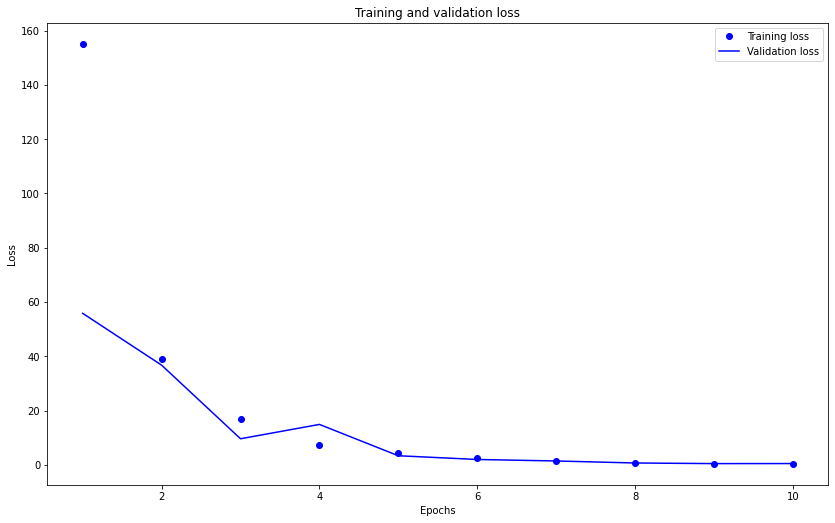

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

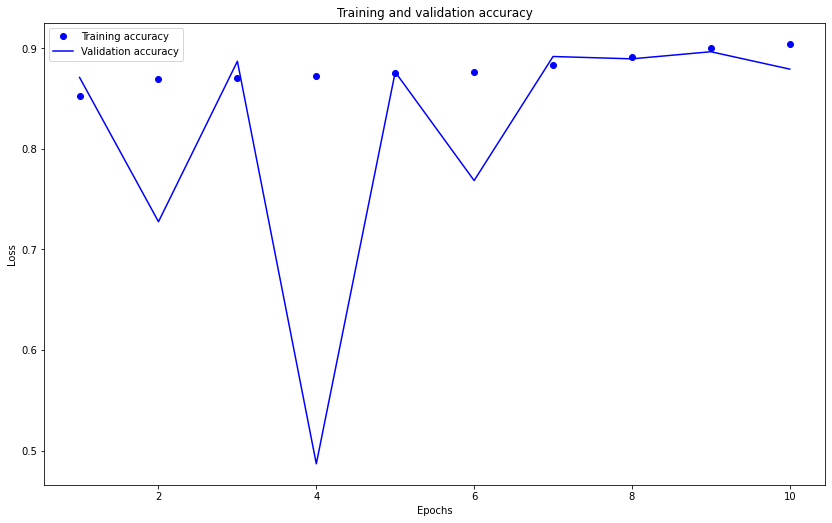

In [35]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We managed to reach an accuracy that is close to 90%. This may not sound bad but we can definitely apply tweaks to our data and to the network architecture that can lead us to impresive results.

Stay tuned.

### That's it for now!
Please bear in mind that this jupyter notebook's intention was just to
* Perform a baseline run for crop classification over a small part of the Netherlands
* Evaluate the results of a very common shallow learning and a very simple deep learning model
* The data didn't undergo any kind of sophisticated preprocessing. There is still a lot way to go in this regard.
* The Random Forest classifier used was not fine-tuned at all
* Same applies for the *very* simple Neural Network that was employed.
* We only used Sentinel-2 data. Data fusion will matter a lot in the near future of the project.
* There are tons of improvements that can be applied, even in this baseilne run. Some of the improvements are already noted in the below section. But if you are reading this and you can see something that you wish to contribute, feel free to do that!
* This notebook should ideally become version controlled, and it soon will. I'll be moving it to AgriHub's GitHub.

#### Potential future notebook improvements
* Check if the feature space file reading should change. Currently I am providing a list of file names. But I think that what would make more sense is to only provide the shapefile directory and then automatically read all the csvs in there.
* I need to revisit the utility functions, understand them and re-write them to clear technical debt.
* Documentation on NOA/AgriHub-originating functionality (like the utility functions) should be thorough, describing arguments, inputs, outputs etc.
* The starting and ending day of year (`start_doy` and `end_doy` variables) are now passed manually. This is not good. We need to derive the start and end of year from the first and last column (feature) of the feature space dataset. (Look at the `daily_fs` utility function for example and fix it)
* Interpolation method should be possible to be passed on to `daily_fs` with a default value.
* Translate the LPIS dataset. If I remember correctly this is a functionality that `geopandas` offer.
* The number of layers and neurons in each layer for the Neural Network should not be hardcoded but occuring from the data.